# 사전학습 모델을 이용한 전이학습

- 이미지넷 대회에서 `MNIST`, `CRFAR10` 데이터 세트로 우수한 성적을 거둔 모델들을 `Keras`에서 구현되어있음
- `Keras`에서 사전학습된 모델을 가져와 데이터에 적용해보겠다.

## Keras Pretrained Model Loading

In [ ]:
#from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, Xception

In [ ]:
# 모델을 불러오면 자동으로 구현된 모델을 확인할 수 있다.
# 학습이 안된 모델을 불러올 수 있다.
model = VGG16()
model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

- 직접 특징 추출을 위한 레이어에 대한 조정하는 대신, 사전학습 모델의 특징 추출을 위한 최적의 레이어 세팅을 그대로 사용한다.
- 그 이후에 예측을 위한 Full Conected Layer 설계는 원하는 레이어로 지정하여 설계하여 사용하겠다.

In [ ]:
# weights='imagenet'으로 모델이 학습한 내용을 불러올 수도 있다.
model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

- 특징 추출하는 방법 공부잘하는 애꺼쓰고 ㅋ
- pollin 예측하는 부분은 내 마음대로 지정해서 수정 가능

### Functional Model 확인

In [ ]:
print('model:', model)
print('model output:', model.output)

model: <keras.engine.functional.Functional object at 0x7fc360176990>
model output: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


## Pretrained 모델을 기반으로 CIFAR 10 분류 모델 재생성

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

### `VGG16` 모델의 최종 특징 추출의 output만 가져오기

### 특징 추출 이후 Full Connected Layer 설정
- 평탄화 기법 : `GlobalAveragePooling2D` 사용
- 은닉층 : `dense layer` 통과
- 출력층 : `dense layer`의 유닛(뉴런)의 개수를 클래스 개수 10으로 지정후 `softmax` 활성화 함수 적용해 최종 output 반환

### 모델 생성
- 입력 데이터를 사전학습 모델의 특정 추출값과 설정한 Full Conncevted Layer를 통과하여 모델 생성

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

# include_top=False로 기존 imagenet용 classifier 층들을 다 제거. weight는 전이학습을 위해 imagenet 학습된 weight를 초기 weight로 사용.
#input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
bm_output = base_model.output # Feature Extraction의 마지막 부분을 의미(최종 특징 추출 단계)

# base model의 output을 입력으로 CIFAR10용 Classification layer를 재 구성.
# Flatten 레이어를 GlobalAveragePooling2D로 변경
x = GlobalAveragePooling2D()(bm_output) # GAP :  평탄화 기법 중 하나
# x = Dropout(rate=0.5)(x)
x = Dense(50, activation='relu', name='fc1')(x)
# x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax', name='output')(x)

#model = Model(inputs=input_tensor, outputs=output)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

- 평탄화 기법
1. `Flattern()`
  - 채널 수가 512개 미만일 경우 사용(논문 결과)
2. `GlobalAveragePoolin2D()`
  - 채널 수가 512개 이상일 경우 사용
  - 채널 수가 512개 이상일 때 `Flattern()` 단점이 커지기 때문에 대안으로 나온 평탄화기법
  - 각 채널별 피처맵 데이터의 평균을 구한다.
- 각 데이터의 모양이 (7, 7, 512)일 때
  - `Flattern()`으로 평탄화하면 $7*7*512$개의 데이터가 나오고
  - `GlobalAveragePoolin2D()`으로 평탄화하면 512개 나온다.

---

## 데이터 전처리

### 데이터 전처리를 위한 함수 정의

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음.
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):

    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형.
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)

    labels = np.array(labels, dtype=np.float32)

    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용.
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )


# random seed는 2021로 고정.
set_random_seed(2021)
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성.
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


## ImageDataGenerator로 Augmentation 설정하고 학습용, 검증용 Generator 생성

## Keras CNN 모델 생성 함수 정의

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):

    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    #x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    #x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()

    return model

## 모델 생성 및 모델 컴파일
-  모델의 훈련을 위한 손실함수, 최적화. 평가지표를 지정하는 컴파일 작업 수행



In [ ]:
vgg_model = create_model(verbose=True)
vgg_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# steps 횟수를 구하기 위해 학습 데이터의 건수와 검증 데이터의 건수를 구함. steps = ceil(학습 데이터 건수/BATCH_SIZE)
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = vgg_model.fit(flow_tr_gen, epochs=40,
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
                    validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/40
665/665 [==============================] - 33s 25ms/step - loss: 1.8729 - accuracy: 0.2488 - val_loss: 1.5167 - val_accuracy: 0.3848
Epoch 2/40
665/665 [==============================] - 16s 24ms/step - loss: 1.3315 - accuracy: 0.4856 - val_loss: 1.2003 - val_accuracy: 0.5732
Epoch 3/40
665/665 [==============================] - 16s 24ms/step - loss: 1.0117 - accuracy: 0.6471 - val_loss: 0.9944 - val_accuracy: 0.6601
Epoch 4/40
665/665 [==============================] - 16s 24ms/step - loss: 0.8379 - accuracy: 0.7173 - val_loss: 0.8373 - val_accuracy: 0.7353
Epoch 5/40
665/665 [==============================] - 16s 24ms/step - loss: 0.7415 - accuracy: 0.7530 - val_loss: 0.7109 - val_accuracy: 0.7689
Epoch 6/40
665/665 [==============================] - 16s 24ms/step - loss: 0.6593 - accuracy: 0.7823 - val_loss: 0.6537 - val_accuracy: 0.7891
Epoch 7/40
665/665 [==============================] - 16s 24ms/step - loss: 0.6022 - accuracy: 0.8024 - val_loss: 0.6326 - val_accuracy:

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
vgg_model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 9ms/step - loss: 1.0857 - accuracy: 0.8472


[1.085679292678833, 0.8471999764442444]

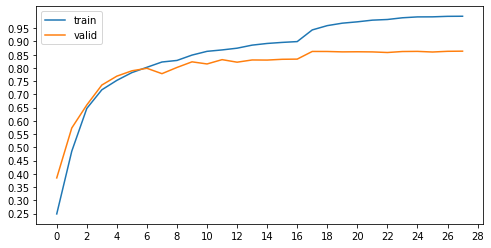

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

## [총정리] 지금까지의 로직들을 함수화

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

# seed 를 설정해서 학습시마다 동일한 결과 유도. 불행히도 의도한 대로 동작하지 않음.
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):

    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형.
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)

    labels = np.array(labels, dtype=np.float32)

    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용.
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )

# 입력 image의 크기를 resize 값 만큼 증가. CIFAR10의 이미지가 32x32로 작아서 마지막 feature map의 크기가 1로 되어 모델 성능이 좋지 않음.
# 마지막 feature map의 크기를 2로 만들기 위해 resize를 64로 하여 입력 이미지 크기를 변경. 단 메모리를 크게 소비하므로 64이상은 kernel이 다운됨.
def get_resized_images(images, resize=64):
    image_cnt = images.shape[0]
    resized_images = np.zeros((images.shape[0], resize, resize, 3))
    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image

    return resized_images

def create_model(model_name='vgg16', verbose=False):

    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')

    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()

    return model

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

def do_cifar10_train_evaluation(image_size=IMAGE_SIZE, model_name='vgg16'):
    set_random_seed(2021)
    # CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성.
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
    print('데이터 세트 shape:', tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

    # 만약 image_size가 32보다 크면 이미지 크기 재조정.
    if image_size > 32:
        tr_images = get_resized_images(tr_images)
        val_images = get_resized_images(val_images)
        test_images = get_resized_images(test_images)

    # 학습/검증/테스트용 ImageDataGenerator와 flow로 pipeline 생성.
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255.0
    )
    valid_generator = ImageDataGenerator(rescale=1/255.0)
    test_generator = ImageDataGenerator(rescale=1/255.0)

    flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
    flow_test_gen = train_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

    # model_name 에 따른 모델 생성하고 모델 학습 및 검증 수행.
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
    # 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
    ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

    tr_data_len = tr_images.shape[0]
    val_data_len = val_images.shape[0]
    history = model.fit(flow_tr_gen, epochs=40,
                        steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
                        validation_data=flow_val_gen, validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                        callbacks=[rlr_cb, ely_cb])
    # 테스트 데이터 세트로 모델 성능 검증
    evaluation_result = model.evaluate(flow_test_gen)
    print('테스트 데이터 세트 evaluation 결과:', evaluation_result)
    return history, evaluation_result


In [ ]:
import gc

gc.collect()

3916

In [ ]:
# 만약 image_size를 64로 하려면 반드시 RAM이 여유분이 충분히 있는지 확인 후 진행
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

데이터 세트 shape: (42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)
83697664/83683744 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Act

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


665/665 [==============================] - 53s 74ms/step - loss: 0.7484 - accuracy: 0.7533 - val_loss: 0.5515 - val_accuracy: 0.8324
Epoch 2/40
665/665 [==============================] - 48s 73ms/step - loss: 0.4046 - accuracy: 0.8676 - val_loss: 0.6244 - val_accuracy: 0.8137
Epoch 3/40
665/665 [==============================] - 48s 73ms/step - loss: 0.3103 - accuracy: 0.8982 - val_loss: 0.4075 - val_accuracy: 0.8723
Epoch 4/40
665/665 [==============================] - 48s 73ms/step - loss: 0.2555 - accuracy: 0.9146 - val_loss: 0.6146 - val_accuracy: 0.8325
Epoch 5/40
665/665 [==============================] - 48s 73ms/step - loss: 0.2379 - accuracy: 0.9223 - val_loss: 0.3721 - val_accuracy: 0.8840
Epoch 6/40
665/665 [==============================] - 48s 73ms/step - loss: 0.1744 - accuracy: 0.9441 - val_loss: 0.3735 - val_accuracy: 0.8888
Epoch 7/40
665/665 [==============================] - 48s 73ms/step - loss: 0.1491 - accuracy: 0.9512 - val_loss: 0.3996 - val_accuracy: 0.8769
Epo

In [ ]:
print('테스트 데이터세트 검증 결과:', evaluation_result)

테스트 데이터세트 검증 결과: [0.3841651678085327, 0.9329000115394592]


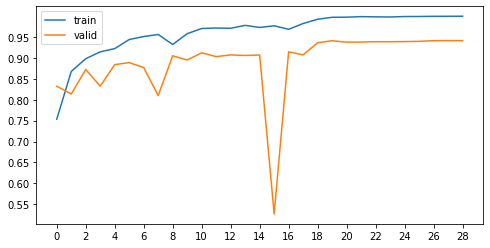

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)